# Conditional Volatility of Cryptocurrencies

- Value at Risk, Expected Shortfall, GARCH, EWMA
- Cryptocurrencies: bitcoin, etherium

Copyright 2023, Terence Lim

MIT License

In [1]:
import numpy as np
from scipy.stats import chi2, norm, t, jarque_bera, kurtosis, skew
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns 
from finds.alfred import Alfred
from finds.recipes import kupiecLR, pof, halflife, RiskMeasure
from finds.display import show
from conf import VERBOSE, credentials, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)
imgdir = paths['images'] / 'ts'
alf = Alfred(api_key=credentials['fred']['api_key'])

## Histogram, VaR and ES of Cryptocurrencies

,std dev,skewness,excess kurtosis,jarque-bera pvalue
CBBTCUSD,0.0426,-1.8736,48.9911,0.0
CBETHUSD,0.0556,-0.4426,4.7691,0.0
CBBCHUSD,0.0625,-0.5600,11.5654,0.0
CBLTCUSD,0.0588,0.7586,9.4610,0.0


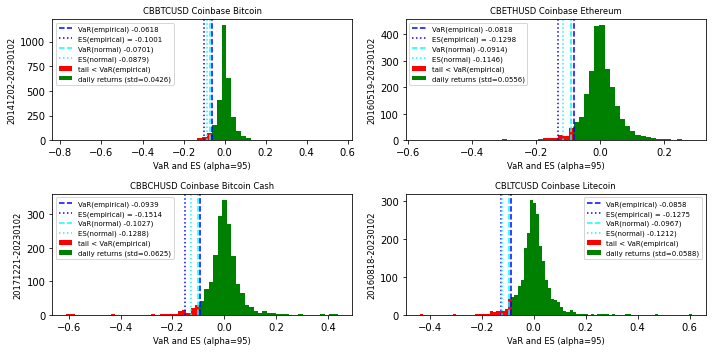

In [2]:
labels = ['CBBTCUSD', 'CBETHUSD', 'CBBCHUSD', 'CBLTCUSD']
alpha = 0.95   # VaR parameter
out = {}
fig, axes = plt.subplots(2, 2, num=1, clear=True, figsize=(10, 5))
for label, ax in zip(labels, list(axes.ravel())):
    rets = alf(label, log=1, diff=1).dropna()
    sigma = rets.std()
    risk_measure = RiskMeasure(rets, alpha=0.95)
    var = risk_measure.value_at_risk()
    es = risk_measure.expected_shortfall()
    var_normal = risk_measure.value_at_risk(normal=True)
    es_normal = risk_measure.expected_shortfall(normal=True)
    
    n, bins, _ = ax.hist(rets[rets < var], color='red', bins=30)
    stepsize = (bins[-1] - bins[0]) / (len(bins) - 1)
    bins = np.arange(var, max(rets) + stepsize, stepsize)
    ax.hist(rets[rets >= var], color='green', bins=bins)

    ax.axvline(var, color='blue', ls='--')
    ax.axvline(es, color='blue', ls=':')
    ax.axvline(var_normal, color='cyan', ls='--')
    ax.axvline(es_normal, color='cyan', ls=':')
    ax.legend([f'VaR(empirical) {var:.4f}',
               f'ES(empirical) = {es:.4f}',
               f'VaR(normal) {var_normal:.4f})',
               f'ES(normal) {es_normal:.4f})',
               'tail < VaR(empirical)',
               f'daily returns (std={sigma:.4f})'], fontsize='x-small')
    ax.set_title(f"{label} {alf.header(label)[:60]}",
                 {'fontsize' : 'small'})
    ax.set_ylabel(f'{min(rets.index)}-{max(rets.index)}',
                  fontsize='small')
    ax.set_xlabel(f'VaR and ES (alpha={alpha*100:.0f})',
                  fontsize='small')
    out[label] = {'std dev': np.std(rets, ddof=1),
                  'skewness': skew(rets),
                  'excess kurtosis': kurtosis(rets)-3,
                  'jarque-bera pvalue': jarque_bera(rets)[1]}
plt.tight_layout()
plt.savefig(imgdir / 'es.jpg')

# Non-normal: Jacque-Bera, excess kurtosis, mixtures
show(DataFrame(out).T, **SHOW)

## GARCH(1,1) wrapper around rugarch

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR
def rugarch(rets: Series, savefig: str = '') -> np.array:
    rugarch_ro = importr('rugarch')  # to use library rugarch
    c_ = ro.r['c']
    list_ = ro.r['list']
    spec = ro.r['ugarchspec'](mean_model=list_(armaOrder=c_(0, 0),
                                               include_mean=False))
    model = ro.r['ugarchfit'](spec, data=PyR(rets.values).ro) 
    ro.r['show'](model)

    if savefig:
        for which in [4, 5, 10, 11]:
            ro.r['plot'](model, which=which)
            PyR.savefig(imgdir / f'{savefig}{which}.png')
    return PyR(ro.r['sigma'](model)).values  # fitted volatility values

## Retrive Bitcoin from FRED and plot GARCH, EWMA and Daily Returns


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002181    0.000589   3.7042 0.000212
omega   0.000091    0.000013   6.9373 0.000000
alpha1  0.197710    0.018396  10.7477 0.000000
beta1   0.780395    0.016824  46.3859 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002181    0.000660   3.3041 0.000953
omega   0.000091    0.000037   2.4581 0.013967
alpha1  0.197710    0.063783   3.0998 0.001937
beta1   0.780395    0.047028  16.5942 0.000000

LogLikelihood : 5486.844 

Information Criteria
------------------------------------
                    
Akaike       -3.7567
Bayes        -3.7485
Shibata      -3.7567
Hannan-Quinn -3.7537

Weig

,std dev,skewness,excess kurtosis,pof(95),pof p-value
CBBTCUSD,,,,,
CBBTCUSD,0.0426,-1.8730,48.9794,0.0358,0.0003
EWMA(0.94),1.1405,-1.1434,16.3134,0.0465,0.3969
EWMA(0.97),1.0822,-1.5627,18.8869,0.0437,0.1177
"GARCH(1,1)",1.0237,-0.8266,8.8439,0.0415,0.0346


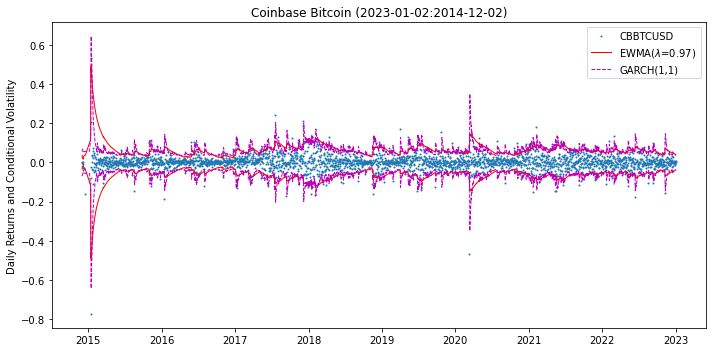

In [4]:
series_id = 'CBBTCUSD'
X = alf(series_id, log=1, diff=1).dropna()
X.index = pd.DatetimeIndex(X.index.astype(str), freq='infer')
Y = np.square(X)

lam = 0.97
asset = np.sqrt((Y.ewm(alpha=1 - lam).mean()).rename('EWMA')).to_frame()
asset['EWMA(0.94)'] = np.sqrt((Y.ewm(alpha=1 - 0.94).mean()))
asset['GARCH'] = rugarch(X)

# Conditional Volatility Models EWMA(94), EWMA(97), GARCH(1, 1): Bitcoin
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
ax.plot(X.shift(-1), ls='', marker='.', markersize=2)
ax.plot(norm.ppf(1 - alpha) * asset['EWMA'], lw=1, ls='-', c='r')
ax.plot(norm.ppf(1 - alpha) * asset['GARCH'], lw=1, ls='--', c='m')
ax.set_title(alf.header(series_id)
             + f" ({max(Y.index).strftime('%Y-%m-%d')}:"
             + f"{min(Y.index).strftime('%Y-%m-%d')})")
ax.set_ylabel('Daily Returns and Conditional Volatility')
ax.legend([series_id] + [f"EWMA($\lambda$={lam:.2f})"] + ['GARCH(1,1)'])
ax.plot(-norm.ppf(1 - alpha) * asset['EWMA'], lw=1, ls='-', c='r')
ax.plot(-norm.ppf(1 - alpha) * asset['GARCH'], lw=1, ls='--', c='m')
plt.tight_layout()
plt.savefig(imgdir / 'ewma.jpg')

# Statistical summary of conditional volatility models
y = X.shift(-1)
results = {}
for label, x in zip([series_id, 'EWMA(0.94)', f'EWMA({lam:.2f})','GARCH(1,1)'],
                    [1.0, asset['EWMA(0.94)'], asset['EWMA'], asset['GARCH']]):
    if isinstance(x, (int, float)):
        pof_ = pof((y / np.std(y))[126:], x)  # skip first six months
    else: 
        pof_ = pof(y[126:], x[126:])  # skip first six months
    results[label] = {'std dev': np.std(y.div(x).dropna()),
                      'skewness': skew(y.div(x).dropna()),
                      'excess kurtosis': kurtosis(y.div(x).dropna()) - 3,
                      f'pof({int(100*alpha)})': pof_['s']/pof_['n'],
                      'pof p-value': pof_['pvalue']}
show(DataFrame.from_dict(results, orient='index'), caption=series_id, **SHOW)